# Part 1: Data Preprocessing

In [107]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import bs4
import re
import requests
import os
import pyarrow.parquet as pq
import glob
import matplotlib.pyplot as plt

### Uber Data

In [2]:
uber_rides_sample = pd.read_csv("uber_rides_sample.csv", index_col = 0)
uber_rides_sample.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


### Download Yellow Taxi Data and get a sample dataset with its size close to Uber Dataset

In [4]:
# result = set()
# for filename in os.listdir("./yellow_taxi"):
#     if filename.endswith(".parquet"):
#         existing_columns = set(pq.ParquetFile("./yellow_taxi/"+filename).schema.names)
#         result = result.union(existing_columns)

# result

In [5]:
# Get Yellow Taxi Parquet files
def download_yellow_taxi_parquet_files():
    response = requests.get("https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page")
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    yellow_records = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    if not os.path.exists("./yellow_taxi"):
        os.makedirs("./yellow_taxi")
    
    for record in yellow_records:
        pattern = r'yellow_tripdata_(2009|201[0-5])-\d{2}\.'
        link = record["href"]
        if re.search(pattern, link):
            filename = os.path.join("yellow_taxi", link.split("/")[-1])
            response = requests.get(link)
            
            with open(filename, "wb") as f:
                f.write(response.content)

In [6]:
"""
Comment the line below if no need to download the Yellow Taxi Parquet files.
"""

# download_yellow_taxi_parquet_files()

'\nComment the line below if no need to download the Yellow Taxi Parquet files.\n'

In [7]:
# Get Yellow Taxi Data sample
def generate_yellow_taxi_df():
    columns_to_select = ['DOLocationID',
                         'End_Lat',
                         'End_Lon',
                         'PULocationID',
                         'Passenger_Count',
                         'Start_Lat',
                         'Start_Lon',
                         'Total_Amt',
                         'Trip_Distance',
                         'Trip_Dropoff_DateTime',
                         'Trip_Pickup_DateTime',
                         'dropoff_datetime',
                         'dropoff_latitude',
                         'dropoff_longitude',
                         'passenger_count',
                         'pickup_datetime',
                         'pickup_latitude',
                         'pickup_longitude',
                         'total_amount',
                         'tpep_dropoff_datetime',
                         'tpep_pickup_datetime',
                         'trip_distance']

    directory = "./yellow_taxi"
    yellow_taix_df = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename.endswith(".parquet"):
            existing_columns = set(pq.ParquetFile("./yellow_taxi/"+filename).schema.names)
            columns_to_read = list(set(columns_to_select) & existing_columns)
            table = pq.read_table("./yellow_taxi/"+filename, columns=columns_to_read)
            df = table.to_pandas()
            random_subset = df.sample(n=3000)
            yellow_taix_df = pd.concat([yellow_taix_df, random_subset], ignore_index=True)
    yellow_taix_df.to_csv("yellow_taxi_ride_sample.csv", index = False)

In [8]:
"""
Comment the line below if the Yellow Taxi Data sample already generated.
"""

# generate_yellow_taxi_df()

'\nComment the line below if the Yellow Taxi Data sample already generated.\n'

In [9]:
yellow_taxi_ride_sample = pd.read_csv("yellow_taxi_ride_sample.csv")
yellow_taxi_ride_sample.head()

,trip_distance,PULocationID,DOLocationID,tpep_pickup_datetime,total_amount,tpep_dropoff_datetime,passenger_count,End_Lon,Start_Lon,Trip_Dropoff_DateTime,...,End_Lat,Start_Lat,Total_Amt,Trip_Pickup_DateTime,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,2.25,230.0,246.0,2011-07-20 08:24:00,10.60,2011-07-20 08:41:00,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.20,255.0,49.0,2011-07-09 01:08:45,15.99,2011-07-09 01:23:43,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.80,236.0,140.0,2011-07-19 11:05:31,8.80,2011-07-19 11:12:37,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.10,239.0,50.0,2011-07-02 20:32:16,6.30,2011-07-02 20:36:31,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.90,24.0,142.0,2011-07-21 11:26:15,7.80,2011-07-21 11:33:37,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_distance          216000 non-null  float64
 1   PULocationID           180000 non-null  float64
 2   DOLocationID           180000 non-null  float64
 3   tpep_pickup_datetime   180000 non-null  object 
 4   total_amount           216000 non-null  float64
 5   tpep_dropoff_datetime  180000 non-null  object 
 6   passenger_count        216000 non-null  float64
 7   End_Lon                36000 non-null   float64
 8   Start_Lon              36000 non-null   float64
 9   Trip_Dropoff_DateTime  36000 non-null   object 
 10  Trip_Distance          36000 non-null   float64
 11  Passenger_Count        36000 non-null   float64
 12  End_Lat                36000 non-null   float64
 13  Start_Lat              36000 non-null   float64
 14  Total_Amt              36000 non-nul

### Data Preprocessing - Yellow Taxi Data
#### Combine columns with the same thing BUT have different column names

In [11]:
def convert_to_datetime(df):
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["Trip_Pickup_DateTime"] = pd.to_datetime(df["Trip_Pickup_DateTime"])
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["Trip_Dropoff_DateTime"] = pd.to_datetime(df["Trip_Dropoff_DateTime"])
    df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
    return df

In [12]:
yellow_taxi_ride_sample = convert_to_datetime(yellow_taxi_ride_sample)
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_distance          216000 non-null  float64       
 1   PULocationID           180000 non-null  float64       
 2   DOLocationID           180000 non-null  float64       
 3   tpep_pickup_datetime   180000 non-null  datetime64[ns]
 4   total_amount           216000 non-null  float64       
 5   tpep_dropoff_datetime  180000 non-null  datetime64[ns]
 6   passenger_count        216000 non-null  float64       
 7   End_Lon                36000 non-null   float64       
 8   Start_Lon              36000 non-null   float64       
 9   Trip_Dropoff_DateTime  36000 non-null   datetime64[ns]
 10  Trip_Distance          36000 non-null   float64       
 11  Passenger_Count        36000 non-null   float64       
 12  End_Lat                36000 non-null   floa

In [13]:
def impute_pickup_datetime(row):
    if pd.notna(row['tpep_pickup_datetime']):
        return row['tpep_pickup_datetime']
    elif pd.notna(row['pickup_datetime']):
        return row['pickup_datetime']
    else:
        return row['Trip_Pickup_DateTime']
    
def impute_dropoff_datetime(row):
    if pd.notna(row['tpep_dropoff_datetime']):
        return row['tpep_dropoff_datetime']
    elif pd.notna(row['dropoff_datetime']):
        return row['dropoff_datetime']
    else:
        return row['Trip_Dropoff_DateTime']
    
def impute_trip_distance(row):
    if pd.notna(row['trip_distance']):
        return row['trip_distance']
    else:
        return row['Trip_Distance']
    
def impute_total_amount(row):
    if pd.notna(row['Total_Amt']):
        return row['Total_Amt']
    else:
        return row['total_amount']
    
def impute_pickup_lon(row):
    if pd.notna(row['pickup_longitude']):
        return row['pickup_longitude']
    else:
        return row['Start_Lon']
    
def impute_pickup_lat(row):
    if pd.notna(row['pickup_latitude']):
        return row['pickup_latitude']
    else:
        return row['Start_Lat']

def impute_dropoff_lon(row):
    if pd.notna(row['dropoff_longitude']):
        return row['dropoff_longitude']
    else:
        return row['End_Lon']

def impute_dropoff_lat(row):
    if pd.notna(row['dropoff_latitude']):
        return row['dropoff_latitude']
    else:
        return row['End_Lat']
    
def impute_passenger_count(row):
    if pd.notna(row['passenger_count']):
        return row['passenger_count']
    else:
        return row['Passenger_Count']

In [14]:
yellow_taxi_ride_sample['pickup_datetime'] = yellow_taxi_ride_sample.apply(impute_pickup_datetime, axis=1)
yellow_taxi_ride_sample['dropoff_datetime'] = yellow_taxi_ride_sample.apply(impute_dropoff_datetime, axis=1)
yellow_taxi_ride_sample['trip_distance'] = yellow_taxi_ride_sample.apply(impute_trip_distance, axis=1)
yellow_taxi_ride_sample['total_amount'] = yellow_taxi_ride_sample.apply(impute_total_amount, axis=1)
yellow_taxi_ride_sample['pickup_longitude'] = yellow_taxi_ride_sample.apply(impute_pickup_lon, axis=1)
yellow_taxi_ride_sample['pickup_latitude'] = yellow_taxi_ride_sample.apply(impute_pickup_lat, axis=1)
yellow_taxi_ride_sample['dropoff_longitude'] = yellow_taxi_ride_sample.apply(impute_dropoff_lon, axis=1)
yellow_taxi_ride_sample['dropoff_latitude'] = yellow_taxi_ride_sample.apply(impute_dropoff_lat, axis=1)
yellow_taxi_ride_sample['passenger_count'] = yellow_taxi_ride_sample.apply(impute_passenger_count, axis=1)
yellow_taxi_ride_sample['passenger_count'] = yellow_taxi_ride_sample['passenger_count'].astype(int)
yellow_taxi_ride_sample = yellow_taxi_ride_sample.drop(columns=['tpep_pickup_datetime', 'Trip_Pickup_DateTime',\
                                                                'tpep_dropoff_datetime', 'Trip_Dropoff_DateTime',\
                                                                'Trip_Distance', 'Total_Amt',\
                                                                'Start_Lon', 'Start_Lat',\
                                                                'End_Lon', 'End_Lat', 'Passenger_Count'])
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      252000 non-null  float64       
 1   PULocationID       180000 non-null  float64       
 2   DOLocationID       180000 non-null  float64       
 3   total_amount       252000 non-null  float64       
 4   passenger_count    252000 non-null  int64         
 5   dropoff_latitude   72000 non-null   float64       
 6   dropoff_datetime   252000 non-null  datetime64[ns]
 7   dropoff_longitude  72000 non-null   float64       
 8   pickup_latitude    72000 non-null   float64       
 9   pickup_datetime    252000 non-null  datetime64[ns]
 10  pickup_longitude   72000 non-null   float64       
dtypes: datetime64[ns](2), float64(8), int64(1)
memory usage: 21.1 MB


#### Deal with  `longitude` , `latitude`, and `Location ID` related problems

In [15]:
nan_rows_PUlon = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_longitude'].isnull() & yellow_taxi_ride_sample['PULocationID'].notnull()]
nan_rows_PUlat = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_latitude'].isnull() & yellow_taxi_ride_sample['PULocationID'].notnull()]
nan_rows_DOlon = yellow_taxi_ride_sample[yellow_taxi_ride_sample['dropoff_longitude'].isnull() & yellow_taxi_ride_sample['DOLocationID'].notnull()]
nan_rows_DOlat = yellow_taxi_ride_sample[yellow_taxi_ride_sample['dropoff_latitude'].isnull() & yellow_taxi_ride_sample['DOLocationID'].notnull()]
nan_rows_lon_lat = pd.concat([nan_rows_PUlon, nan_rows_PUlat, nan_rows_DOlon, nan_rows_DOlat], axis=1)
nan_rows_lon_lat = nan_rows_lon_lat.loc[:, ~nan_rows_lon_lat.columns.duplicated()]
nan_rows_lon_lat

,trip_distance,PULocationID,DOLocationID,total_amount,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,2.25,230.0,246.0,10.60,1,NaN,2011-07-20 08:41:00,NaN,NaN,2011-07-20 08:24:00,NaN
1,3.20,255.0,49.0,15.99,2,NaN,2011-07-09 01:23:43,NaN,NaN,2011-07-09 01:08:45,NaN
2,0.80,236.0,140.0,8.80,1,NaN,2011-07-19 11:12:37,NaN,NaN,2011-07-19 11:05:31,NaN
3,1.10,239.0,50.0,6.30,1,NaN,2011-07-02 20:36:31,NaN,NaN,2011-07-02 20:32:16,NaN
4,1.90,24.0,142.0,7.80,2,NaN,2011-07-21 11:33:37,NaN,NaN,2011-07-21 11:26:15,NaN
...,...,...,...,...,...,...,...,...,...,...,...
248995,0.99,234.0,137.0,8.30,5,NaN,2014-03-13 19:28:00,NaN,NaN,2014-03-13 19:23:00,NaN
248996,2.29,90.0,163.0,11.00,6,NaN,2014-03-30 19:18:00,NaN,NaN,2014-03-30 19:06:00,NaN
248997,1.04,88.0,261.0,14.50,1,NaN,2014-03-05 09:56:00,NaN,NaN,2014-03-05 09:34:00,NaN
248998,0.44,211.0,144.0,7.00,1,NaN,2014-03-19 21:34:00,NaN,NaN,2014-03-19 21:29:00,NaN


In [16]:
rest_rows = yellow_taxi_ride_sample.loc[~yellow_taxi_ride_sample.index.isin(nan_rows_lon_lat.index)]
rows_lon_lat_exist = yellow_taxi_ride_sample[yellow_taxi_ride_sample['pickup_longitude'].notnull() & yellow_taxi_ride_sample['pickup_latitude'].notnull()]
print(f"Check 'rows_lon_lat_exist' and 'nan_rows_lon_lat' forms a partition of 'yellow_taxi_ride_sample': {(rest_rows.copy().drop(['PULocationID', 'DOLocationID'], axis=1)).equals(rows_lon_lat_exist.copy().drop(['PULocationID', 'DOLocationID'], axis=1))}")

Check 'rows_lon_lat_exist' and 'nan_rows_lon_lat' forms a partition of 'yellow_taxi_ride_sample': True


In [17]:
gdf_polygons = gpd.read_file('./taxi_zones/taxi_zones.shp')
gdf_polygons.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [18]:
gdf_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB


In [19]:
def gdf_get_location(df):
    df = gdf_polygons.to_crs(4326)
    df['pickup_lon'] = df['geometry'].centroid.x
    df['pickup_lat'] = df['geometry'].centroid.y
    df['dropoff_lon'] = df['geometry'].centroid.x
    df['dropoff_lat'] = df['geometry'].centroid.y
    return df

In [20]:
gdf_polygons = gdf_get_location(gdf_polygons)
gdf_polygons.head()

/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/3985826996.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['pickup_lon'] = df['geometry'].centroid.x
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/3985826996.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['pickup_lat'] = df['geometry'].centroid.y
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/3985826996.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['dropoff_lon'] = df['geometry'].centroid.x
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykerne

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831,-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745,-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864473,-73.847422,40.864473
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752,-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188485,40.552659,-74.188485,40.552659


In [21]:
gdf_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     263 non-null    int64   
 1   Shape_Leng   263 non-null    float64 
 2   Shape_Area   263 non-null    float64 
 3   zone         263 non-null    object  
 4   LocationID   263 non-null    int64   
 5   borough      263 non-null    object  
 6   geometry     263 non-null    geometry
 7   pickup_lon   263 non-null    float64 
 8   pickup_lat   263 non-null    float64 
 9   dropoff_lon  263 non-null    float64 
 10  dropoff_lat  263 non-null    float64 
dtypes: float64(6), geometry(1), int64(2), object(2)
memory usage: 22.7+ KB


In [22]:
def merge_geo_df(geo_df, df):    
    # Merge nan_rows with geo_df to get the missing longtitude/latitude values
    # We use 'inner' merge to filter the rows with invalid location ID
    merged_nan_rows_PU = pd.merge(df, geo_df[['LocationID', 'pickup_lon', 'pickup_lat']],
                           left_on='PULocationID', right_on='LocationID', how='inner')
    merged_nan_rows = pd.merge(merged_nan_rows_PU, geo_df[['LocationID', 'dropoff_lon', 'dropoff_lat']],
                           left_on='DOLocationID', right_on='LocationID', how='inner')  
    return merged_nan_rows

In [23]:
nan_rows_lon_lat = merge_geo_df(gdf_polygons, nan_rows_lon_lat)
nan_rows_lon_lat['pickup_longitude'] = nan_rows_lon_lat['pickup_lon']
nan_rows_lon_lat['pickup_latitude'] = nan_rows_lon_lat['pickup_lat']
nan_rows_lon_lat['dropoff_longitude'] = nan_rows_lon_lat['dropoff_lon']
nan_rows_lon_lat['dropoff_latitude'] = nan_rows_lon_lat['dropoff_lat']
nan_rows_lon_lat = nan_rows_lon_lat.drop(columns=['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat',\
                                                  'LocationID_x', 'LocationID_y'])
nan_rows_lon_lat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175592 entries, 0 to 175591
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      175592 non-null  float64       
 1   PULocationID       175592 non-null  float64       
 2   DOLocationID       175592 non-null  float64       
 3   total_amount       175592 non-null  float64       
 4   passenger_count    175592 non-null  int64         
 5   dropoff_latitude   175592 non-null  float64       
 6   dropoff_datetime   175592 non-null  datetime64[ns]
 7   dropoff_longitude  175592 non-null  float64       
 8   pickup_latitude    175592 non-null  float64       
 9   pickup_datetime    175592 non-null  datetime64[ns]
 10  pickup_longitude   175592 non-null  float64       
dtypes: datetime64[ns](2), float64(8), int64(1)
memory usage: 16.1 MB


In [24]:
yellow_taxi_ride_sample = pd.concat([nan_rows_lon_lat, rest_rows])
yellow_taxi_ride_sample = yellow_taxi_ride_sample.drop(columns=['PULocationID', 'DOLocationID'])
yellow_taxi_ride_sample

,trip_distance,total_amount,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude
0,2.25,10.60,1,40.753309,2011-07-20 08:41:00,-74.004015,40.759817,2011-07-20 08:24:00,-73.984196
1,0.70,7.20,1,40.753309,2011-07-15 10:03:47,-74.004015,40.759817,2011-07-15 09:56:50,-73.984196
2,1.80,8.60,1,40.753309,2011-07-16 16:59:14,-74.004015,40.759817,2011-07-16 16:48:56,-73.984196
3,0.70,5.80,1,40.753309,2011-07-19 12:42:30,-74.004015,40.759817,2011-07-19 12:36:29,-73.984196
4,1.42,9.25,6,40.753309,2014-06-15 09:56:00,-74.004015,40.759817,2014-06-15 09:49:00,-73.984196
...,...,...,...,...,...,...,...,...,...
251995,10.14,32.95,1,40.770318,2009-05-06 20:20:00,-73.864790,40.757525,2009-05-06 20:01:00,-73.974363
251996,0.90,6.12,1,40.760177,2009-05-03 10:29:12,-73.974411,40.748767,2009-05-03 10:24:29,-73.980141
251997,2.28,7.80,1,40.753040,2009-05-04 22:04:00,-73.969748,40.780570,2009-05-04 21:57:00,-73.952712
251998,0.88,5.40,2,40.747023,2009-05-05 23:37:00,-73.988368,40.747023,2009-05-05 23:32:00,-73.988368


In [25]:
yellow_taxi_ride_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247592 entries, 0 to 251999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_distance      247592 non-null  float64       
 1   total_amount       247592 non-null  float64       
 2   passenger_count    247592 non-null  int64         
 3   dropoff_latitude   247592 non-null  float64       
 4   dropoff_datetime   247592 non-null  datetime64[ns]
 5   dropoff_longitude  247592 non-null  float64       
 6   pickup_latitude    247592 non-null  float64       
 7   pickup_datetime    247592 non-null  datetime64[ns]
 8   pickup_longitude   247592 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 18.9 MB


### Data Preprocessing - Uber Data

In [26]:
uber_rides_sample.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [27]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


In [28]:
#Check missing values
uber_rides_sample.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [29]:
uber_rides_sample['pickup_datetime'] = pd.to_datetime(uber_rides_sample['pickup_datetime'])
uber_rides_sample = uber_rides_sample.drop('key', axis=1) #Since Column 'key' has same values as Column 'pickup_datetime'
uber_rides_sample = uber_rides_sample.dropna() #Since there are very less missing values, we simply drop them
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 24238194 to 11951496
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 12.2 MB


### For Uber and Yellow Taxi data, 
#### remove out of region records

In [30]:
def remove_out_region(df):
    df = df[df['pickup_latitude'] >= 40.560445]
    df = df[df['pickup_latitude'] <= 40.908524]
    df = df[df['dropoff_latitude'] >= 40.560445]
    df = df[df['dropoff_latitude'] <= 40.908524]
    
    df = df[df['pickup_longitude'] >= -74.242330]
    df = df[df['pickup_longitude'] <= -73.71704]
    df = df[df['dropoff_longitude'] >= -74.242330]
    df = df[df['dropoff_longitude'] <= -73.71704]
    return df

In [31]:
yellow_taxi_ride_sample = remove_out_region(yellow_taxi_ride_sample)
uber_rides_sample = remove_out_region(remove_out_region(uber_rides_sample))

####  Calculate trip distance between the pickup and dropoff location

In [32]:
def calculate_trip_distance(row):
    pickup_latitude = row['pickup_latitude']
    pickup_longitude = row['pickup_longitude']
    dropoff_latitude = row['dropoff_latitude']
    dropoff_longitude = row['dropoff_longitude']
    
    lat1, lon1, lat2, lon2 = map(math.radians, [pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    dist = math.sqrt(dlat**2 + dlon**2)
    
    R = 6371
    distance = dist * R
    return distance
    

In [33]:
yellow_taxi_ride_sample['distance_PD'] = yellow_taxi_ride_sample.apply(calculate_trip_distance, axis=1)
uber_rides_sample['distance_PD'] = uber_rides_sample.apply(calculate_trip_distance, axis=1)

#### Filter out zero distance

In [34]:
def remove_zero_distance(df):
    condition = df['distance_PD'] == 0
    df = df.drop(df[condition].index)
    return df

In [35]:
yellow_taxi_ride_sample = remove_zero_distance(yellow_taxi_ride_sample)
uber_rides_sample = remove_zero_distance(uber_rides_sample)

### Cleaned Yellow Taxi Data sample and Uber Data sample

In [36]:
yellow_taxi_ride_sample

,trip_distance,total_amount,passenger_count,dropoff_latitude,dropoff_datetime,dropoff_longitude,pickup_latitude,pickup_datetime,pickup_longitude,distance_PD
0,2.25,10.60,1,40.753309,2011-07-20 08:41:00,-74.004015,40.759817,2011-07-20 08:24:00,-73.984196,2.319521
1,0.70,7.20,1,40.753309,2011-07-15 10:03:47,-74.004015,40.759817,2011-07-15 09:56:50,-73.984196,2.319521
2,1.80,8.60,1,40.753309,2011-07-16 16:59:14,-74.004015,40.759817,2011-07-16 16:48:56,-73.984196,2.319521
3,0.70,5.80,1,40.753309,2011-07-19 12:42:30,-74.004015,40.759817,2011-07-19 12:36:29,-73.984196,2.319521
4,1.42,9.25,6,40.753309,2014-06-15 09:56:00,-74.004015,40.759817,2014-06-15 09:49:00,-73.984196,2.319521
...,...,...,...,...,...,...,...,...,...,...
251994,4.70,14.50,1,40.784239,2009-05-17 03:09:42,-73.949384,40.728252,2009-05-17 02:56:41,-73.975698,6.878798
251995,10.14,32.95,1,40.770318,2009-05-06 20:20:00,-73.864790,40.757525,2009-05-06 20:01:00,-73.974363,12.266722
251996,0.90,6.12,1,40.760177,2009-05-03 10:29:12,-73.974411,40.748767,2009-05-03 10:24:29,-73.980141,1.419733
251997,2.28,7.80,1,40.753040,2009-05-04 22:04:00,-73.969748,40.780570,2009-05-04 21:57:00,-73.952712,3.599911


In [37]:
uber_rides_sample

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_PD
24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683468
27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457725
44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.905407
25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.837874
17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,5.674431
...,...,...,...,...,...,...,...,...
42598914,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.118316
16382965,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,2.460268
27804658,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,15.814454
20259894,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,3.680636


## Weather Data

In [38]:
path = './weather/'
all_files = glob.glob(path + "*.csv")
data_frames = []
for filename in all_files:
    df = pd.read_csv(filename)
    data_frames.append(df)
weather_data = pd.concat(data_frames, axis=0, ignore_index=True)

/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/2213197053.py:5: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/2213197053.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/2213197053.py:5: DtypeWarning: Columns (8,9,17,18,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/2213197053.py:5: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vc/kcpyrcss5c7d8px1l0nqfwrc0000gn/T/ipykernel_63897/2213197053.py:5: DtypeWarning: Columns (9,13) have mixed

In [39]:
weather_data.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2012-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.05,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
1,72505394728,2012-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
2,72505394728,2012-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.08,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
3,72505394728,2012-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.06,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
4,72505394728,2012-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,37,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18


### Hourly Weather Dataset

In [40]:
weather_data_hourly = weather_data.iloc[:, 1:4].join(weather_data.iloc[:, 8:24])
weather_data_hourly.head()

,DATE,LATITUDE,LONGITUDE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
0,2012-01-01T00:51:00,40.77898,-73.96925,30.05,37,46,NaN,NaN,-0.05,1.0,71.0,NaN,30.03,NaN,10.00,NaN,VRB,NaN,6.0
1,2012-01-01T01:51:00,40.77898,-73.96925,30.07,37,45,NaN,NaN,NaN,NaN,76.0,NaN,30.04,NaN,10.00,NaN,VRB,NaN,7.0
2,2012-01-01T02:51:00,40.77898,-73.96925,30.08,37,45,NaN,NaN,NaN,NaN,76.0,NaN,30.05,NaN,10.00,NaN,260,NaN,6.0
3,2012-01-01T03:51:00,40.77898,-73.96925,30.06,37,45,NaN,NaN,-0.01,0.0,76.0,NaN,30.04,NaN,10.00,NaN,290,NaN,5.0
4,2012-01-01T04:51:00,40.77898,-73.96925,30.07,37,43,NaN,NaN,NaN,NaN,81.0,NaN,30.05,NaN,10.00,NaN,000,NaN,0.0


In [41]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       77972 non-null  object 
 1   LATITUDE                   77972 non-null  float64
 2   LONGITUDE                  77972 non-null  float64
 3   HourlyAltimeterSetting     75531 non-null  object 
 4   HourlyDewPointTemperature  76017 non-null  object 
 5   HourlyDryBulbTemperature   76028 non-null  object 
 6   HourlyPrecipitation        39961 non-null  object 
 7   HourlyPresentWeatherType   15357 non-null  object 
 8   HourlyPressureChange       19844 non-null  object 
 9   HourlyPressureTendency     19844 non-null  float64
 10  HourlyRelativeHumidity     76016 non-null  float64
 11  HourlySkyConditions        36313 non-null  object 
 12  HourlySeaLevelPressure     59592 non-null  object 
 13  HourlyStationPressure      37569 non-null  obj

In [42]:
#Check missing values
weather_data_hourly.isnull().sum()

DATE                             0
LATITUDE                         0
LONGITUDE                        0
HourlyAltimeterSetting        2441
HourlyDewPointTemperature     1955
HourlyDryBulbTemperature      1944
HourlyPrecipitation          38011
HourlyPresentWeatherType     62615
HourlyPressureChange         58128
HourlyPressureTendency       58128
HourlyRelativeHumidity        1956
HourlySkyConditions          41659
HourlySeaLevelPressure       18380
HourlyStationPressure        40403
HourlyVisibility              2597
HourlyWetBulbTemperature     40408
HourlyWindDirection           4258
HourlyWindGustSpeed          63945
HourlyWindSpeed               4259
dtype: int64

#### Fills missing values with 0, mean or mode

In [43]:
weather_data_hourly['HourlyStationPressure'] = weather_data_hourly['HourlyStationPressure'].str.replace('s', '')
weather_data_hourly['HourlyStationPressure'] = weather_data_hourly['HourlyStationPressure'].astype(float)

weather_data_hourly['HourlyPrecipitation'].fillna(0, inplace=True)
weather_data_hourly['HourlyPresentWeatherType'].fillna(weather_data_hourly['HourlyPresentWeatherType'].mode()[0], inplace=True)
weather_data_hourly['HourlyPressureTendency'].fillna(weather_data_hourly['HourlyPressureTendency'].mean(), inplace=True)
weather_data_hourly['HourlySkyConditions'].fillna(weather_data_hourly['HourlySkyConditions'].mode()[0], inplace=True)
weather_data_hourly['HourlyStationPressure'].fillna(weather_data_hourly['HourlyStationPressure'].mean(), inplace=True)
weather_data_hourly['HourlyWetBulbTemperature'].fillna(weather_data_hourly['HourlyWetBulbTemperature'].mean(), inplace=True)
weather_data_hourly['HourlyWindGustSpeed'].fillna(weather_data_hourly['HourlyWindGustSpeed'].mean(), inplace=True)

#### Fills missing values with the last known value in the same column

In [44]:
ffill_cols = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity',
              'HourlyVisibility', 'HourlyWindDirection', 'HourlyWindSpeed', 'HourlyPressureChange']
weather_data_hourly[ffill_cols] = weather_data_hourly[ffill_cols].fillna(method='ffill')

#### Fills missing values with the next known value in the same column

In [45]:
bfill_cols = ['HourlySeaLevelPressure']
weather_data_hourly[bfill_cols] = weather_data_hourly[bfill_cols].fillna(method='bfill')

### Cleaned Hourly Weather Dataset

In [46]:
weather_data_hourly

,DATE,LATITUDE,LONGITUDE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
0,2012-01-01T00:51:00,40.77898,-73.96925,30.05,37,46,0,|RA |,-0.05,1.000000,71.0,CLR:00,30.03,29.865065,10.00,49.521217,VRB,21.127112,6.0
1,2012-01-01T01:51:00,40.77898,-73.96925,30.07,37,45,0,|RA |,-0.05,4.266126,76.0,CLR:00,30.04,29.865065,10.00,49.521217,VRB,21.127112,7.0
2,2012-01-01T02:51:00,40.77898,-73.96925,30.08,37,45,0,|RA |,-0.05,4.266126,76.0,CLR:00,30.05,29.865065,10.00,49.521217,260,21.127112,6.0
3,2012-01-01T03:51:00,40.77898,-73.96925,30.06,37,45,0,|RA |,-0.01,0.000000,76.0,CLR:00,30.04,29.865065,10.00,49.521217,290,21.127112,5.0
4,2012-01-01T04:51:00,40.77898,-73.96925,30.07,37,43,0,|RA |,-0.01,4.266126,81.0,CLR:00,30.05,29.865065,10.00,49.521217,000,21.127112,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77967,2010-12-31T19:51:00,40.77898,-73.96925,30.18,28.0,43.0,0,|RA |,-0.03,4.266126,57.0,CLR:00,30.16,29.865065,7.0,49.521217,VRB,21.127112,5.0
77968,2010-12-31T20:51:00,40.77898,-73.96925,30.18,28.0,43.0,0,|RA |,-0.03,4.266126,57.0,CLR:00,30.16,29.865065,7.0,49.521217,VRB,21.127112,7.0
77969,2010-12-31T21:51:00,40.77898,-73.96925,30.19,28.0,43.0,0,|RA |,0.01,5.000000,57.0,CLR:00,30.16,29.865065,7.0,49.521217,VRB,21.127112,7.0
77970,2010-12-31T22:51:00,40.77898,-73.96925,30.17,28.0,43.0,0,|RA |,0.01,4.266126,57.0,CLR:00,30.14,29.865065,7.0,49.521217,240,21.127112,6.0


In [47]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       77972 non-null  object 
 1   LATITUDE                   77972 non-null  float64
 2   LONGITUDE                  77972 non-null  float64
 3   HourlyAltimeterSetting     77972 non-null  object 
 4   HourlyDewPointTemperature  77972 non-null  object 
 5   HourlyDryBulbTemperature   77972 non-null  object 
 6   HourlyPrecipitation        77972 non-null  object 
 7   HourlyPresentWeatherType   77972 non-null  object 
 8   HourlyPressureChange       77972 non-null  object 
 9   HourlyPressureTendency     77972 non-null  float64
 10  HourlyRelativeHumidity     77972 non-null  float64
 11  HourlySkyConditions        77972 non-null  object 
 12  HourlySeaLevelPressure     77972 non-null  object 
 13  HourlyStationPressure      77972 non-null  flo

# Part 2: Storing Data

In [49]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///project.db', echo=True)
# Base.metadata.create_all(engine)

### Four tables

In [53]:
uber_rides_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193514 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        193514 non-null  float64            
 1   pickup_datetime    193514 non-null  datetime64[ns, UTC]
 2   pickup_longitude   193514 non-null  float64            
 3   pickup_latitude    193514 non-null  float64            
 4   dropoff_longitude  193514 non-null  float64            
 5   dropoff_latitude   193514 non-null  float64            
 6   passenger_count    193514 non-null  int64              
 7   distance_PD        193514 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 13.3 MB


In [54]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77972 entries, 0 to 77971
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       77972 non-null  object 
 1   LATITUDE                   77972 non-null  float64
 2   LONGITUDE                  77972 non-null  float64
 3   HourlyAltimeterSetting     77972 non-null  object 
 4   HourlyDewPointTemperature  77972 non-null  object 
 5   HourlyDryBulbTemperature   77972 non-null  object 
 6   HourlyPrecipitation        77972 non-null  object 
 7   HourlyPresentWeatherType   77972 non-null  object 
 8   HourlyPressureChange       77972 non-null  object 
 9   HourlyPressureTendency     77972 non-null  float64
 10  HourlyRelativeHumidity     77972 non-null  float64
 11  HourlySkyConditions        77972 non-null  object 
 12  HourlySeaLevelPressure     77972 non-null  object 
 13  HourlyStationPressure      77972 non-null  flo

In [79]:
import sqlite3
connection = sqlite3.connect("project.db")

#Yellow Taxi trips
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS yellow_taxi_ride (
            id INTEGER PRIMARY KEY,
            trip_distance REAL,
            passenger_count INTEGER,
            total_amount REAL,
            dropoff_datetime DATETIME,
            pickup_longitude REAL,
            pickup_latitude REAL,
            dropoff_latitude REAL,
            dropoff_longitude REAL,
            pickup_datetime DATETIME,
            distance_PD REAL,
            tip_amount REAL
        );
        """
    )

#Uber trips
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS uber_rides (
            id INTEGER PRIMARY KEY,
            fare_amount REAL,
            pickup_datetime DATETIME,
            pickup_longitude REAL,
            pickup_latitude REAL,
            dropoff_longitude REAL,
            dropoff_latitude REAL,
            passenger_count INTEGER,
            distance_PD REAL
        );
        """
    )
    
#Hourly Weather
with connection:
    connection.execute(
        """
        CREATE TABLE IF NOT EXISTS hourly_weather_data (
            id INTEGER PRIMARY KEY,
            DATE DATETIME,
            LATITUDE REAL,
            LONGITUDE REAL,
            HourlyAltimeterSetting REAL,
            HourlyDewPointTemperature INTEGER,
            HourlyDryBulbTemperature INTEGER,
            HourlyPrecipitation REAL,
            HourlyPresentWeatherType TEXT, 
            HourlyPressureChange REAL,
            HourlyPressureTendency REAL,
            HourlyRelativeHumidity REAL,
            HourlySkyConditions, REAL 
            HourlySeaLevelPressure REAL,
            HourlyStationPressure REAL,
            HourlyVisibility REAL,
            HourlyWetBulbTemperature REAL,
            HourlyWindDirection REAL,
            HourlyWindGustSpeed REAL,
            HourlyWindSpeed REAL
        );
        """
    )

In [80]:
with engine.connect() as conn:
    yellow_taxi_ride_sample.to_sql('yellow_taxi_ride', conn, if_exists='replace', index=False)
    uber_rides_sample.to_sql('uber_rides', conn, if_exists='replace', index=False)
    weather_data_hourly.to_sql('hourly_weather_data', conn, if_exists='replace', index=False)

2023-04-30 00:24:10,355 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi_ride")
2023-04-30 00:24:10,356 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 00:24:10,358 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi_ride")
2023-04-30 00:24:10,358 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 00:24:10,360 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2023-04-30 00:24:10,360 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 00:24:10,361 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("yellow_taxi_ride")
2023-04-30 00:24:10,361 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-30 00:24:10,363 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2023-04-30 00:24:10,363 INFO sqlalchemy.engine.Engine [raw sql] ('yellow_taxi_ride',)
2023-04-30 00:24:10,365 INFO sqlalchemy.engine.Engine PR

2023-04-30 00:24:11,901 INFO sqlalchemy.engine.Engine [no key 0.00022s] ()
2023-04-30 00:24:11,902 INFO sqlalchemy.engine.Engine COMMIT
2023-04-30 00:24:12,635 INFO sqlalchemy.engine.Engine INSERT INTO uber_rides (fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, "distance_PD") VALUES (?, ?, ?, ?, ?, ?, ?, ?)
2023-04-30 00:24:12,635 INFO sqlalchemy.engine.Engine [generated in 0.58916s] ((7.5, '2015-05-07 19:52:06.000000', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1, 1.683468372889847), (7.7, '2009-07-17 20:04:56.000000', -73.994355, 40.728225, -73.99471, 40.750325, 1, 2.4577249023006513), (12.9, '2009-08-24 21:45:00.000000', -74.005043, 40.74077, -73.962565, 40.772647, 1, 5.905407110501063), (5.3, '2009-06-26 08:22:21.000000', -73.976124, 40.790844, -73.965316, 40.803349, 3, 1.837873830108156), (16.0, '2014-08-28 17:47:00.000000', -73.925023, 40.744085, -73.97308199999999, 40.761247, 5

In [81]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table'")
tables = cur.fetchall()

with open('schema.sql', 'w') as f:
    for table in tables:
        f.write(f'{table[1]};\n')
        
cur.close()
conn.close()

# Part 3: Understanding Data

## Query 1

In [104]:
query1 = """
SELECT 
    strftime('%H', pickup_datetime) AS hour_of_day,
    COUNT(*) AS ride_count
FROM 
    yellow_taxi_ride 
WHERE 
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY 
    hour_of_day 
ORDER BY 
    ride_count DESC;
"""

In [109]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query1)
results1 = cur.fetchall()

for row in results1:
    print(row)

conn.close()

('19', 13575)
('18', 13185)
('20', 12914)
('21', 12617)
('22', 12117)
('14', 10996)
('23', 10944)
('17', 10797)
('13', 10567)
('12', 10546)
('15', 10425)
('09', 9979)
('11', 9972)
('08', 9734)
('10', 9571)
('16', 8745)
('00', 8701)
('07', 7809)
('01', 6271)
('02', 4644)
('06', 4487)
('03', 3559)
('04', 2612)
('05', 2127)


In [110]:
results1

[('19', 13575),
 ('18', 13185),
 ('20', 12914),
 ('21', 12617),
 ('22', 12117),
 ('14', 10996),
 ('23', 10944),
 ('17', 10797),
 ('13', 10567),
 ('12', 10546),
 ('15', 10425),
 ('09', 9979),
 ('11', 9972),
 ('08', 9734),
 ('10', 9571),
 ('16', 8745),
 ('00', 8701),
 ('07', 7809),
 ('01', 6271),
 ('02', 4644),
 ('06', 4487),
 ('03', 3559),
 ('04', 2612),
 ('05', 2127)]

## Query 2

In [90]:
query2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM 
    uber_rides
WHERE 
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY 
    day_of_week 
ORDER BY 
    ride_count DESC;
"""

In [91]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query2)
results2 = cur.fetchall()

for row in results2:
    print(row)

conn.close()

('5', 29845)
('6', 29320)
('4', 29050)
('3', 28068)
('2', 27197)
('0', 25572)
('1', 24398)


## Query 3

In [98]:
query3 = """
SELECT CAST((SELECT distance_PD
             FROM (
               SELECT distance_PD, NTILE(100) OVER (ORDER BY distance_PD) AS percentile
               FROM (
                 SELECT distance_PD FROM yellow_taxi_ride WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
                 UNION ALL
                 SELECT distance_PD FROM uber_rides WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
               ) AS hired_trips
             )
             WHERE percentile = 95
             LIMIT 1) AS REAL) AS percentile_95;
"""

In [99]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query3)
results3 = cur.fetchall()

for row in results3:
    print(row)

conn.close()

(11.923711190871654,)


## Query 4

In [102]:
query4 = """
SELECT
    date(date_time) AS date,
    SUM(num_rides) AS num_rides,
    AVG(avg_distance) AS avg_distance
FROM
    (
    SELECT
        dropoff_datetime AS date_time,
        1 AS num_rides,
        trip_distance AS avg_distance
    FROM
        yellow_taxi_ride
    WHERE
        strftime('%Y-%m', dropoff_datetime) BETWEEN '2009-01' AND '2009-06'
    
    UNION ALL
    
    SELECT
        pickup_datetime AS date_time,
        1 AS num_rides,
        distance_PD AS avg_distance
    FROM
        uber_rides
    WHERE
        strftime('%Y-%m', pickup_datetime) BETWEEN '2009-01' AND '2009-06'
    ) AS hired_rides
GROUP BY
    date
ORDER BY
    num_rides DESC
LIMIT
    10;
"""

In [103]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query4)
results4 = cur.fetchall()

for row in results4:
    print(row)

conn.close()

('2009-04-04', 235, 2.7642219964199537)
('2009-04-18', 219, 3.1032805932949064)
('2009-02-26', 218, 3.2148415200843945)
('2009-02-20', 218, 2.960428247045675)
('2009-03-19', 216, 3.106485971424462)
('2009-05-16', 213, 2.9867293927390492)
('2009-03-20', 212, 3.263225173269454)
('2009-02-06', 212, 2.8016193959142592)
('2009-03-26', 211, 2.9101964440273056)
('2009-02-14', 211, 3.202048976228742)


## Query 5

In [ ]:
query5 = """

"""

In [ ]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query5)
results5 = cur.fetchall()

for row in results5:
    print(row)

conn.close()

## Query 6

In [ ]:
query6 = """

"""

In [ ]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()
cur.execute(query6)
results6 = cur.fetchall()

for row in results6:
    print(row)

conn.close()

# Part 4: Visualizing Data

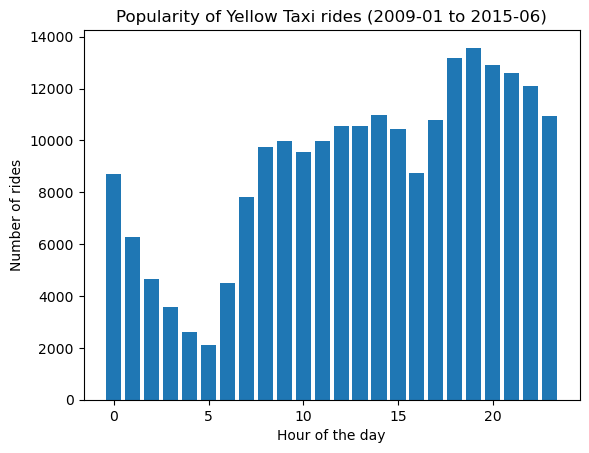

In [111]:
# 1
x = [int(row[0]) for row in results1]
y = [row[1] for row in results1]

fig, ax = plt.subplots()
ax.bar(x, y)

ax.set_xlabel('Hour of the day')
ax.set_ylabel('Number of rides')
ax.set_title('Popularity of Yellow Taxi rides (2009-01 to 2015-06)')

plt.show()

In [117]:
conn = sqlite3.connect('project.db')
cur = conn.cursor()

cur.execute("""
    SELECT strftime('%m', pickup_datetime) AS month, 
           AVG(trip_distance) AS avg_distance, 
           1.645 * STDDEV(trip_distance) / COUNT(*) AS error
    FROM yellow_taxi_ride
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
    GROUP BY month
    UNION
    SELECT strftime('%m', pickup_datetime) AS month, 
           AVG(distance_PD) AS avg_distance, 
           1.645 * STDDEV(distance_PD) / COUNT(*) AS error
    FROM uber_rides
    WHERE pickup_datetime BETWEEN '2010-01-01' AND '2015-06-30'
    GROUP BY month
""")

# fetch the results as a pandas dataframe
results = pd.DataFrame(cursor.fetchall(), columns=['month', 'avg_distance', 'error'])

# set the month column as the index
results.set_index('month', inplace=True)

# convert the index to datetime format for proper sorting
results.index = pd.to_datetime(results.index, format='%m')

# sort the dataframe by month
results.sort_index(inplace=True)

# create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# plot the data as a line chart with error bars
ax.errorbar(results.index, results.avg_distance, yerr=results.error, fmt='-o')

# set the title and labels
ax.set_title('Average Distance Traveled per Month for Yellow Taxis and Ubers')
ax.set_xlabel('Month')
ax.set_ylabel('Average Distance Traveled')

# show the plot
plt.show()


OperationalError: no such function: STDDEV